# Plot colony growth rate of Staph-Pseudomonas co-culture

To run this code install ipympl if you have not yet done so:

`conda install -c conda-forge ipympl`

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#path handling
import pathlib

## Load data

In [2]:
#Run ones to make test data
# df_1 = pd.read_csv('20230411/20230411_pos000.csv', index_col=0)
# df_2 = pd.read_csv('20230411/20230411_pos004.csv', index_col=0)
# df = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)
# df['colony_id'] = df['col_idx'].astype(int) #temp needed to fix bug in test data
# df.drop(columns=['col_idx'], inplace=True)
# df.to_csv('20230411_all_data.csv')

In [3]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
exp_name = "20230411"

#read data
csv_name = path_data_files / f"{exp_name}_all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)

We now remove the PA data, as we only care about SA growth. 

We also removed untracked colonies. 

Finally we create a unique id for each colony by combining pos with colony_id

Then we plot number of colonies as function of time, to choose the final time point to analyze (before too many colonies merge)

In [4]:
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['colony_id']>=0)].copy()
unique_id = df['strain'].map(str) + '-' + df['pos'].map(str) + '-' + df['colony_id'].map(str)  
df['unique_id'] = unique_id
df.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,frame,pos,strain,condition,colony_id,min_dist_PA_centroid,unique_id
0,1,818,80.063570,1266.731051,35.040071,31.224062,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,0,180.846496,SA1-0-0
1,2,735,89.469388,1374.753741,43.489829,23.046311,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,1,224.546857,SA1-0-1
2,3,777,102.608752,1551.871300,34.768511,29.621879,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,2,105.645573,SA1-0-2
3,4,235,171.485106,1580.600000,23.340537,13.144388,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,3,88.521595,SA1-0-3
4,5,1282,224.416537,1096.703588,59.640729,28.771840,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,4,130.954679,SA1-0-4


to compare growth of colonies we first normalize area to 1 in first frame and than take log

In [6]:
# add normalized area
df['area'] = df['area'].astype(float)
df['lognorm_area'] = np.log(df['area'].div(df.groupby('unique_id')['area'].transform('first')))
df['log_area_change'] = df.groupby('unique_id')['lognorm_area'].diff(1)

Below we plot log area trajectories of unfiltered data

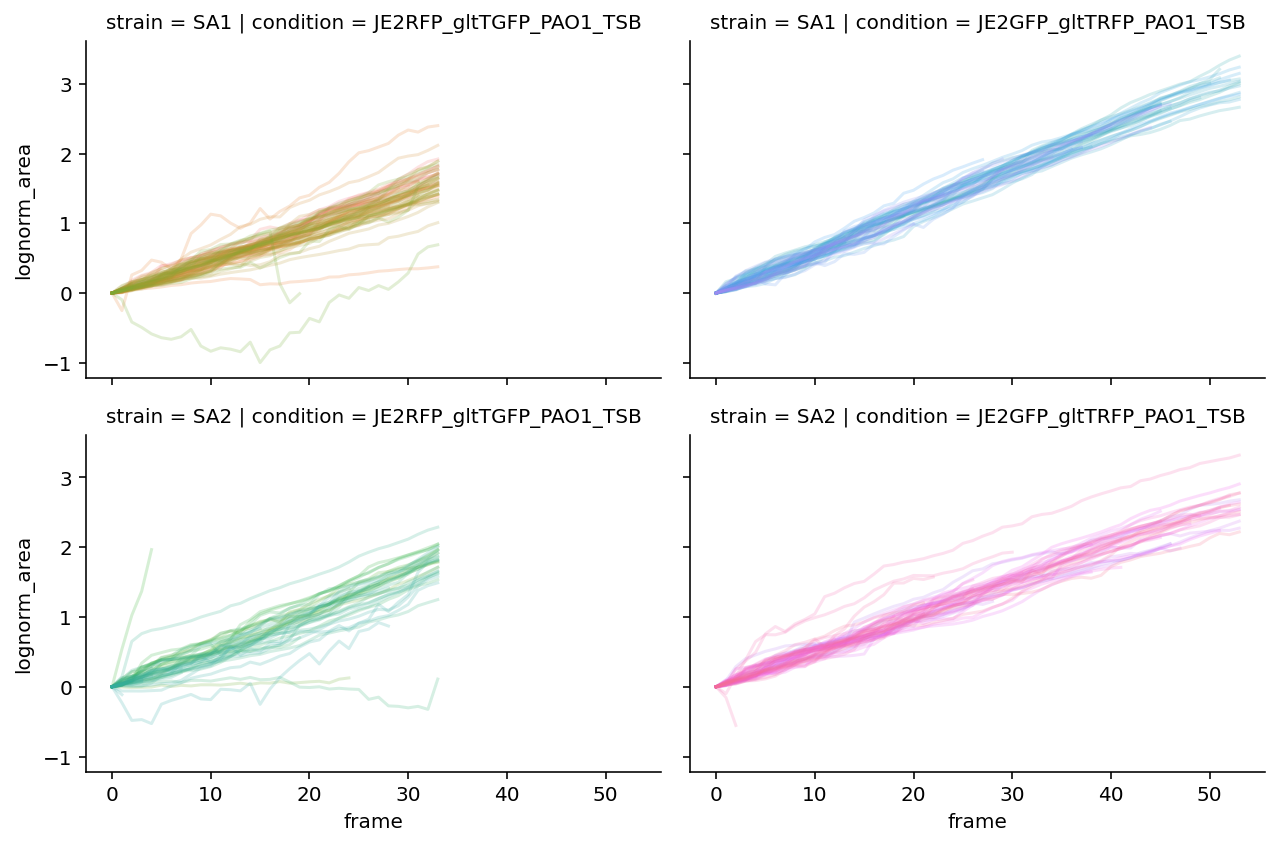

In [10]:
g = sns.FacetGrid(data=df, col='condition',row='strain',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='frame', y='lognorm_area', alpha=0.2)

We see there are some weird trajectories which we need to remove.
We do automatic filtering by calculate the log length change between two frames and cutting trajectories when this becomes too big or small.

(-0.2, 0.3)

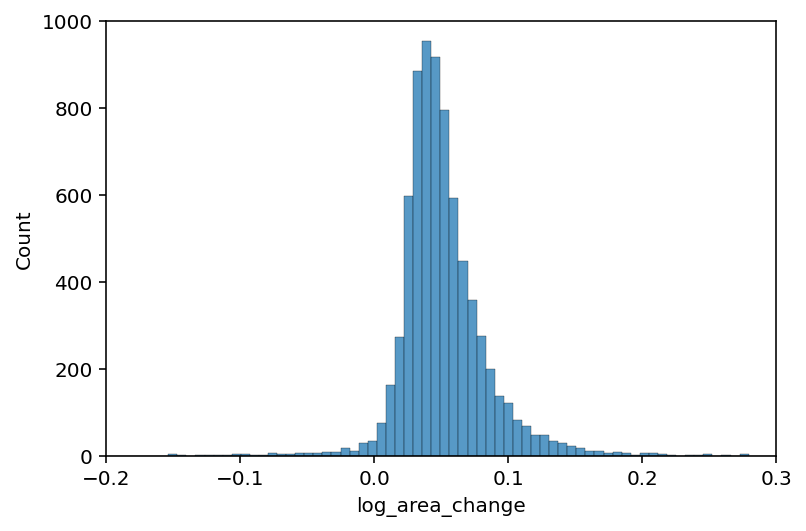

In [11]:
sns.histplot(data=df, x='log_area_change', bins=200).set_xlim(-0.2,0.3)

Based on histogram we can set max change in length (corresponds to max growth rate)

In [14]:
min_dl = -0.06
max_dl = 0.2
df['track_error'] = (df['log_area_change']<min_dl) | (df['log_area_change']>max_dl)
track_filter = df.groupby('unique_id')['track_error'].cumsum() > 0
df_filtered = df.loc[~track_filter].copy()

And now of filtered data, we see that we removed/cropped the erroneous trajectories 

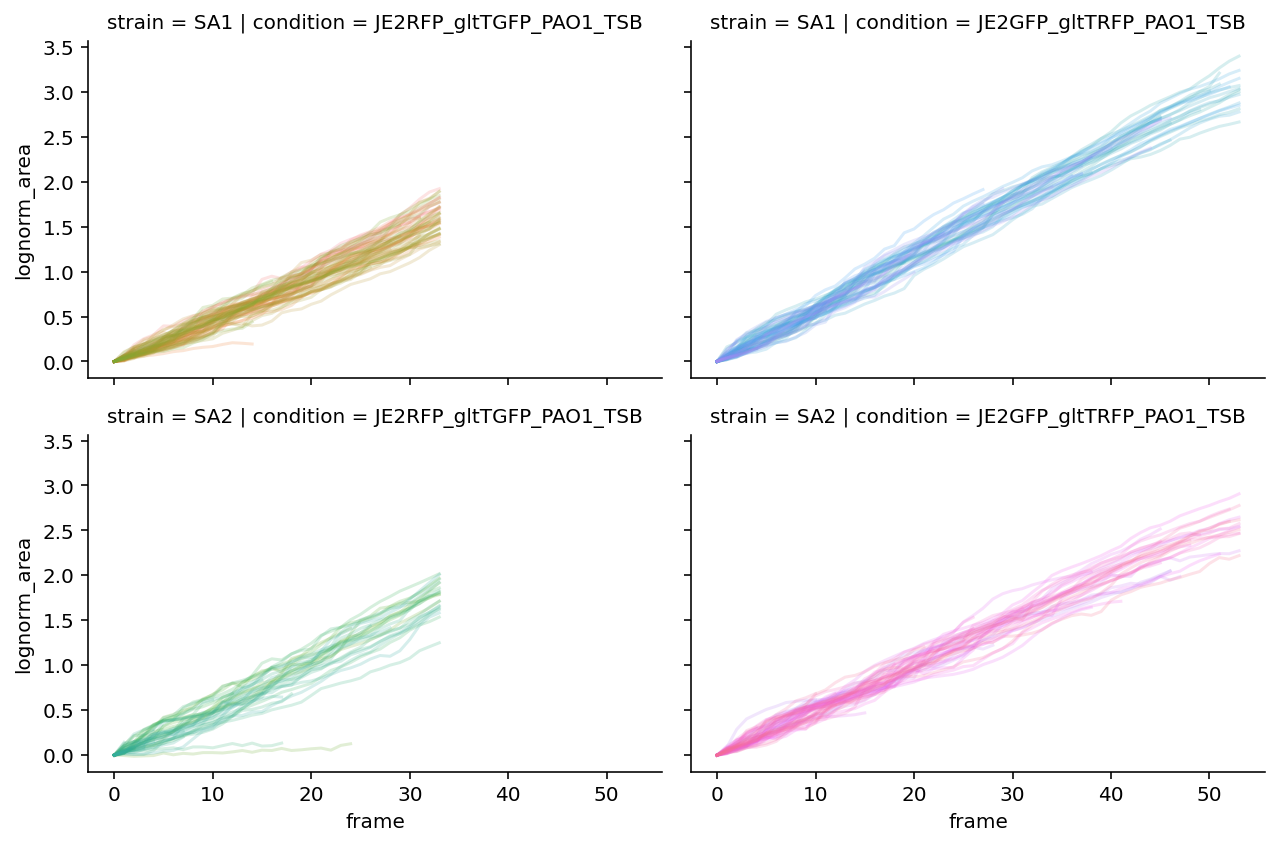

In [15]:
g = sns.FacetGrid(data=df_filtered, col='condition',row='strain',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='frame', y='lognorm_area', alpha=0.2)

Let's check how many colonies we can track as function of time:

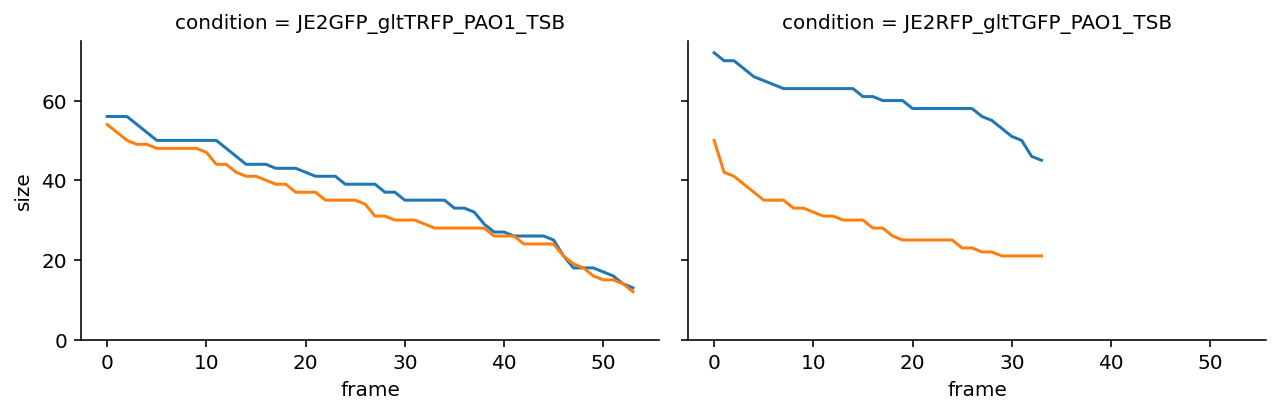

In [24]:
col_num_t = df_filtered.groupby(['strain','frame','condition'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, col='condition',hue='strain',aspect=1.5)
g.map_dataframe(sns.lineplot, x='frame', y='size')
g.set(ylim=(0, None))

Now that we have clean trajectories we can calculate the growth rates:

In [17]:
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

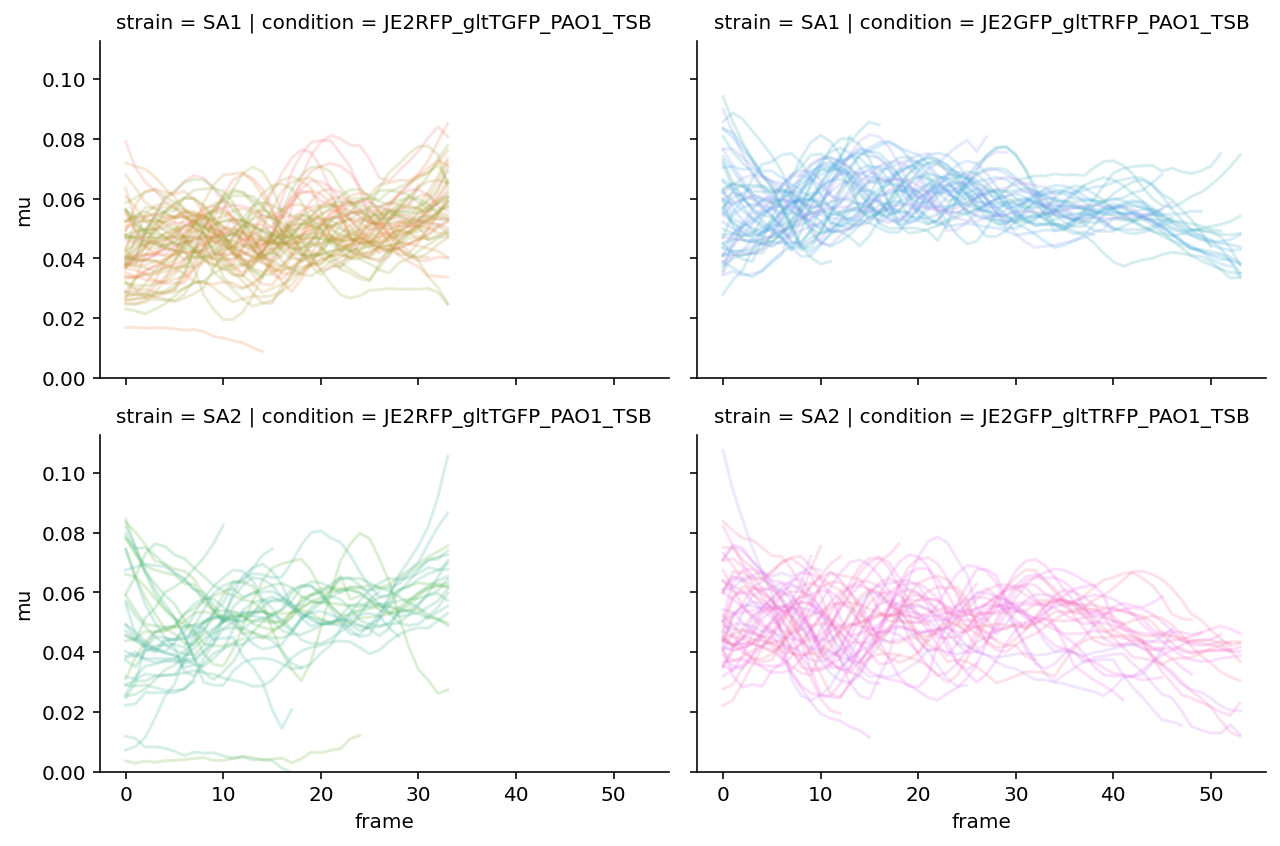

In [50]:
df_filtered['mu'] = df_filtered.groupby('unique_id')['area'].rolling(11, min_periods=6, center=True).apply(derivative, kwargs={'frm_interval':1, 'log':True}).reset_index(0,drop=True)

g = sns.FacetGrid(data=df_filtered, col='condition',row='strain',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='frame', y='mu', alpha=0.2)
g.set(ylim=(0, None))

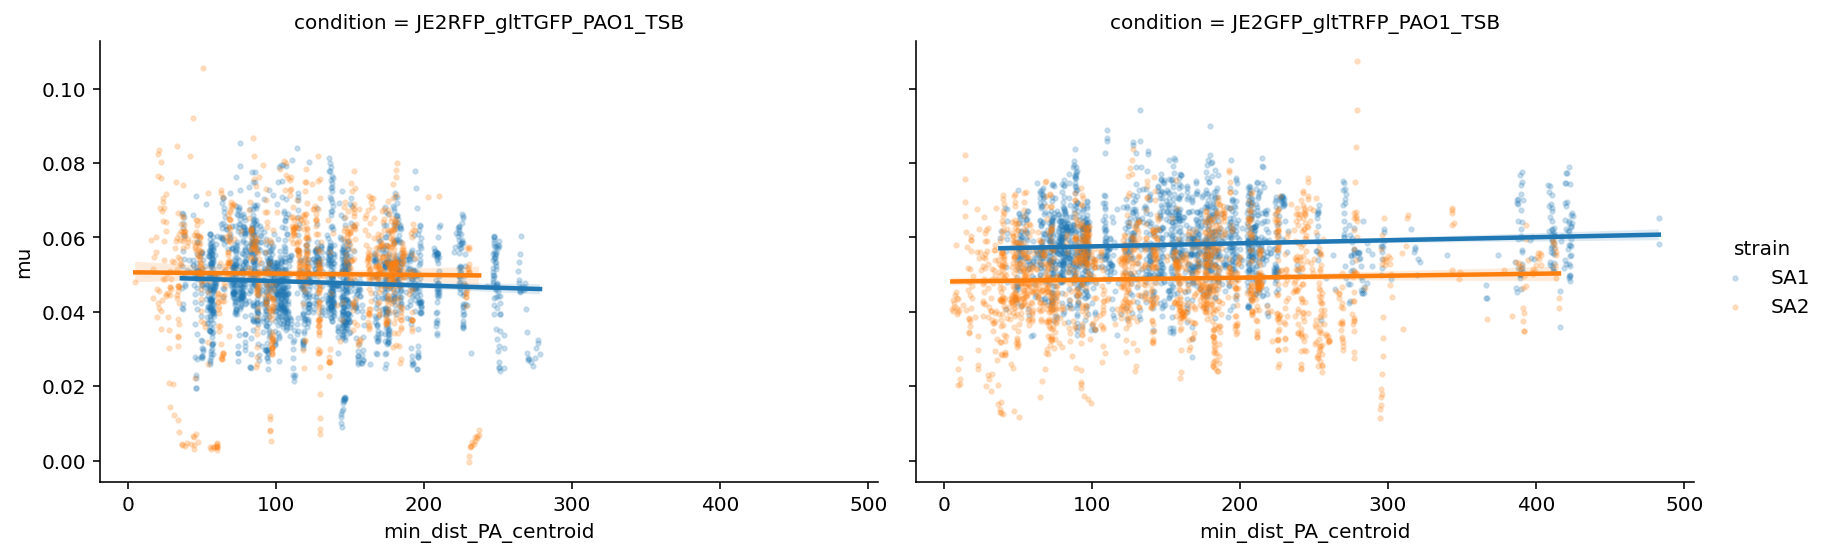

In [64]:
# g = sns.FacetGrid(data=df_filtered, col='condition',row='strain',aspect=1.5).add_legend()
# g.map_dataframe(sns.scatterplot, x='min_dist_PA_centroid', y='mu', s=10, alpha=0.2)

sns.lmplot(data=df_filtered, x='min_dist_PA_centroid', y='mu', col='condition', hue='strain', scatter_kws={'s':5,'alpha':0.2}, aspect=1.5, height=4)

Next we calculate total growth difference for different time points

In [114]:
def summary_stats(x, period=10):
    '''create summary stats for each colony
    
    Parameters
    ----------
    x : pandas dataframe
        dataframe with colony data
    period : int
        number of frames to calculate stats over
    
    Returns
    -------
    d : Pandas Series
        Pandas series with summary stats
    '''
    
    #calculate growth rate
    start_area = x['area'].iloc[0]    
    end_area = x['area'].iloc[period] if x['area'].size > period else np.nan
    growth = np.log(end_area/start_area) / period

    d = {}
    d['centroid-0_av'] = x['centroid-0'].mean()
    d['centroid-1_av'] = x['centroid-1'].mean()
    d['dist_PA_centroid_av'] = x['min_dist_PA_centroid'].mean()
    d['dist_PA_centroid_min'] = x['min_dist_PA_centroid'].min()
    d['dist_PA_centroid_start'] = x['min_dist_PA_centroid'].iloc[0]
    d['strain'] = x['strain'].iloc[0]
    d['condition'] = x['condition'].iloc[0]
    d['colony_id'] = x['colony_id'].iloc[0]
    d['unique_id'] = x['unique_id'].iloc[0]
    d['area_start'] = start_area
    d['area_end'] = end_area
    d['growth'] = growth
    
    d['period' ] = period
        
    index = ['period','centroid-0_av', 'centroid-1_av', 'dist_PA_centroid_av', 'dist_PA_centroid_min', 'dist_PA_centroid_start', 'strain', 'condition', 'colony_id', 'unique_id', 'area_start', 'area_end', 'growth']

    return pd.Series(d, index=index)

In [122]:
t_analyze = [20, 30, 40, 50]
dfList = [df_filtered.groupby('unique_id').apply(summary_stats, period=period).reset_index(drop=True) for period in t_analyze]
df_summary = pd.concat(dfList, axis=0, ignore_index=True)
df_summary.head()

,period,centroid-0_av,centroid-1_av,dist_PA_centroid_av,dist_PA_centroid_min,dist_PA_centroid_start,strain,condition,colony_id,unique_id,area_start,area_end,growth
0,20,82.502006,1267.300817,180.213425,177.247826,180.846496,SA1,JE2RFP_gltTGFP_PAO1_TSB,0,SA1-0-0,818.0,2506.0,0.055979
1,20,91.893131,1374.645310,223.999488,220.448294,224.546857,SA1,JE2RFP_gltTGFP_PAO1_TSB,1,SA1-0-1,735.0,2045.0,0.051164
2,20,388.039521,1642.400123,145.224006,144.284581,145.020578,SA1,JE2RFP_gltTGFP_PAO1_TSB,10,SA1-0-10,845.0,1954.0,0.041915
3,20,401.964594,851.119506,73.675753,71.694180,74.653284,SA1,JE2RFP_gltTGFP_PAO1_TSB,11,SA1-0-11,312.0,727.0,0.042296
4,20,426.194445,1182.170035,173.870390,169.374039,176.536434,SA1,JE2RFP_gltTGFP_PAO1_TSB,12,SA1-0-12,712.0,1728.0,0.044332


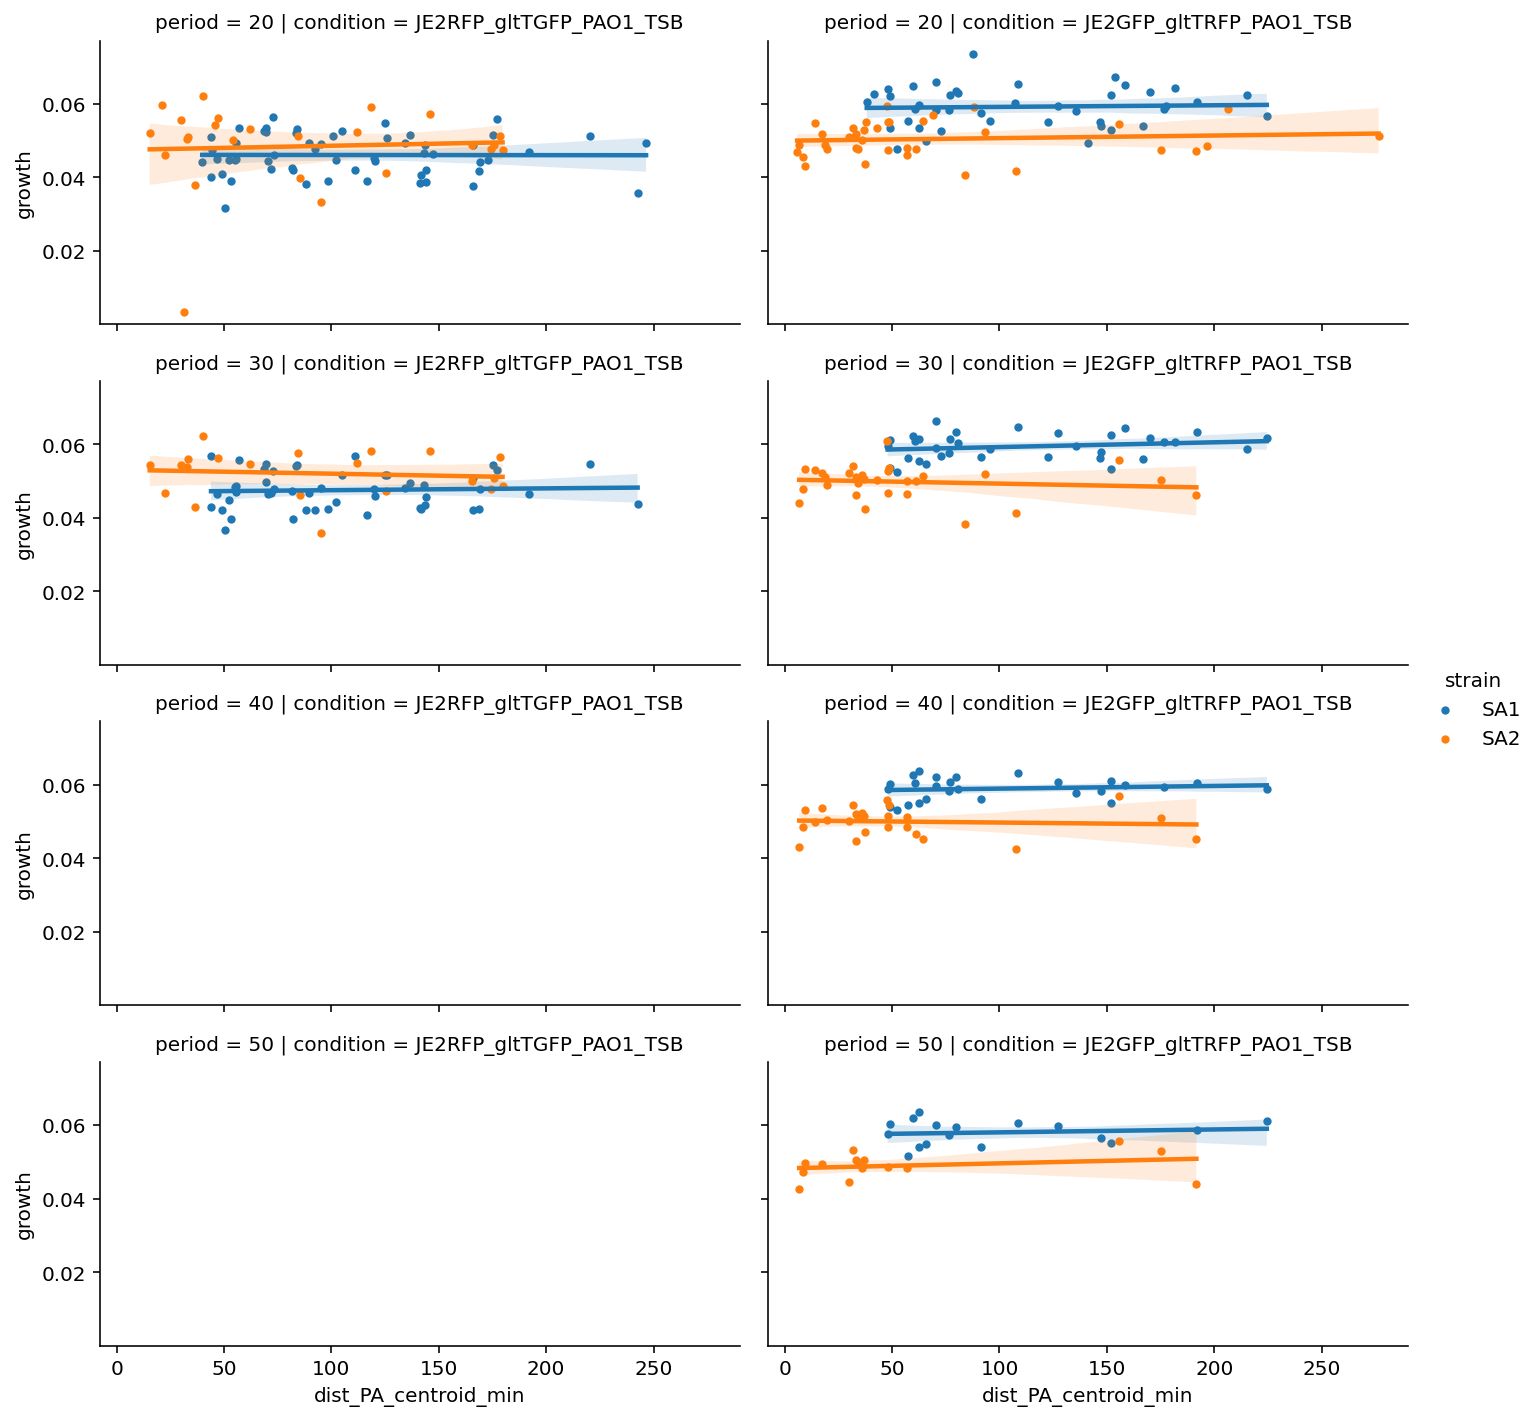

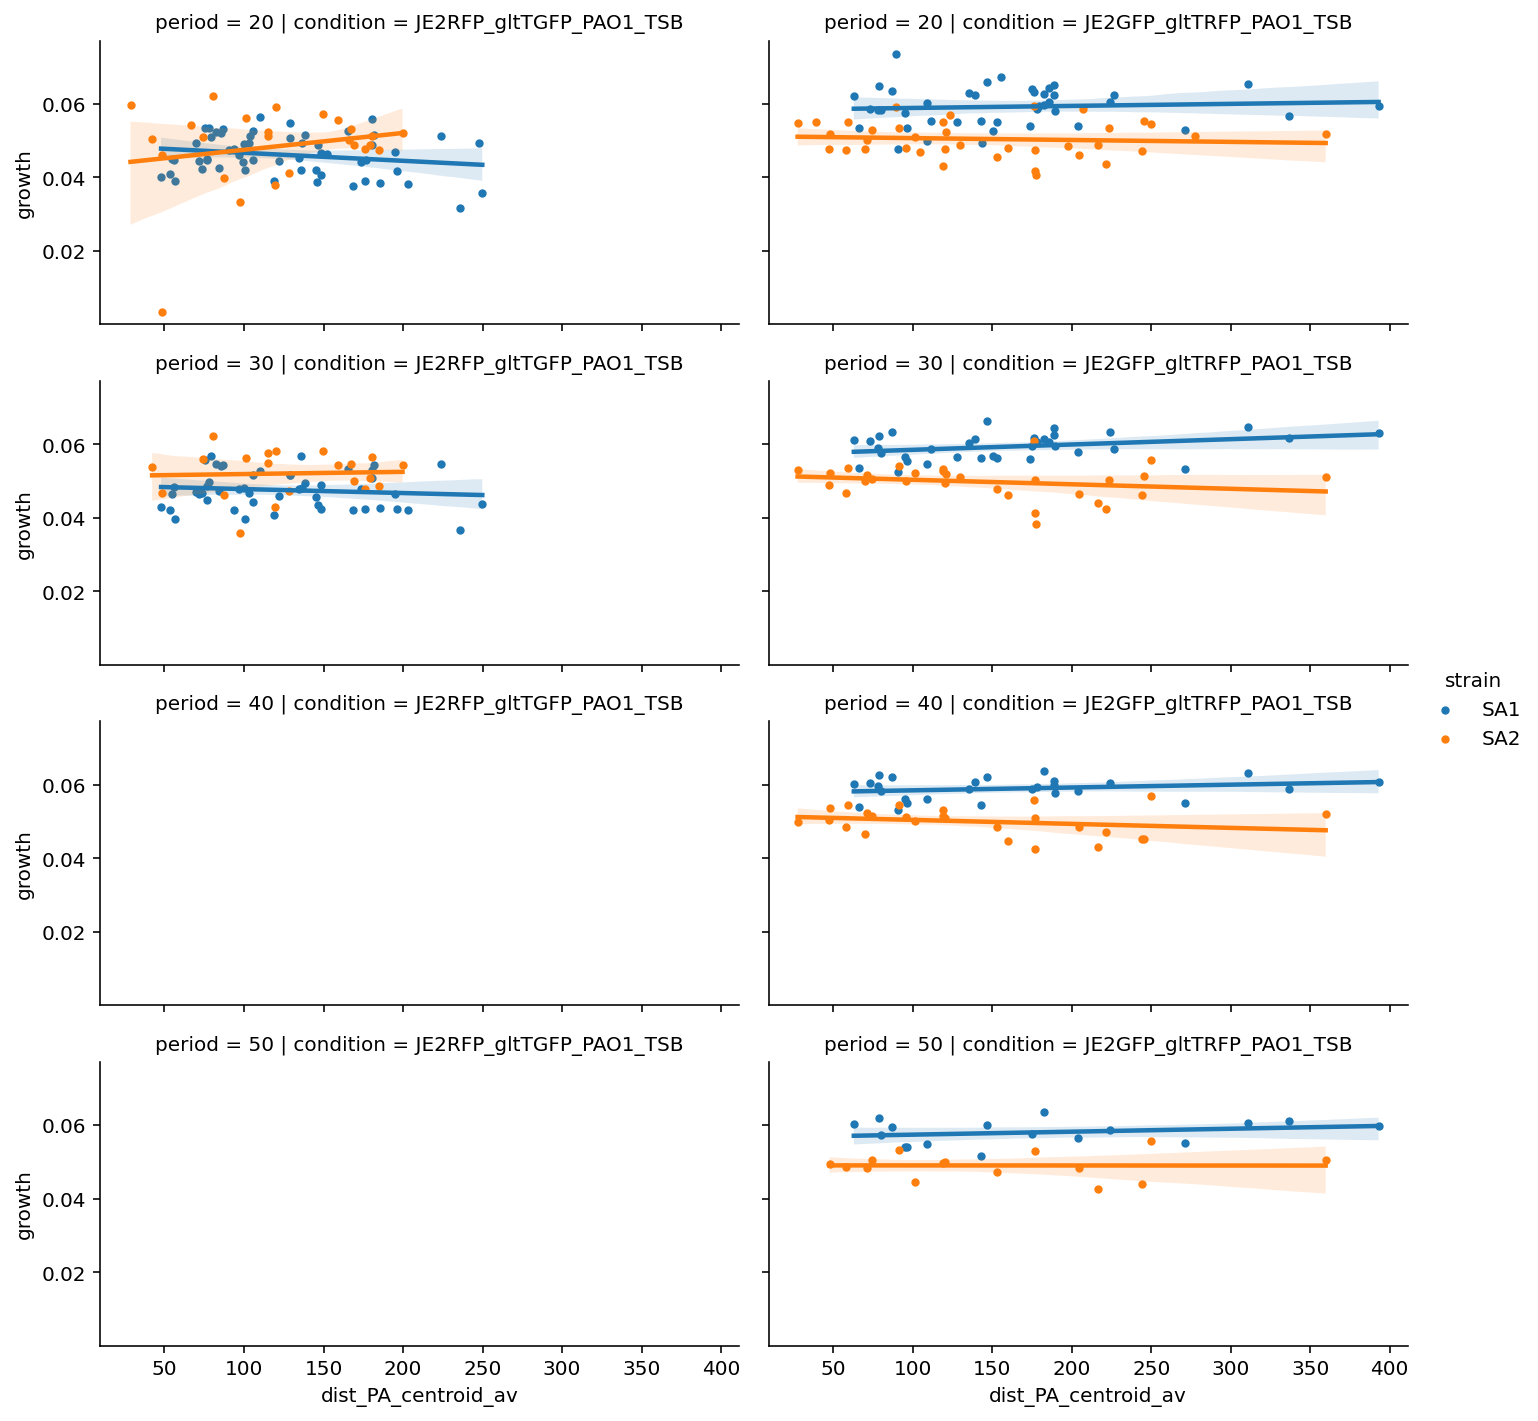

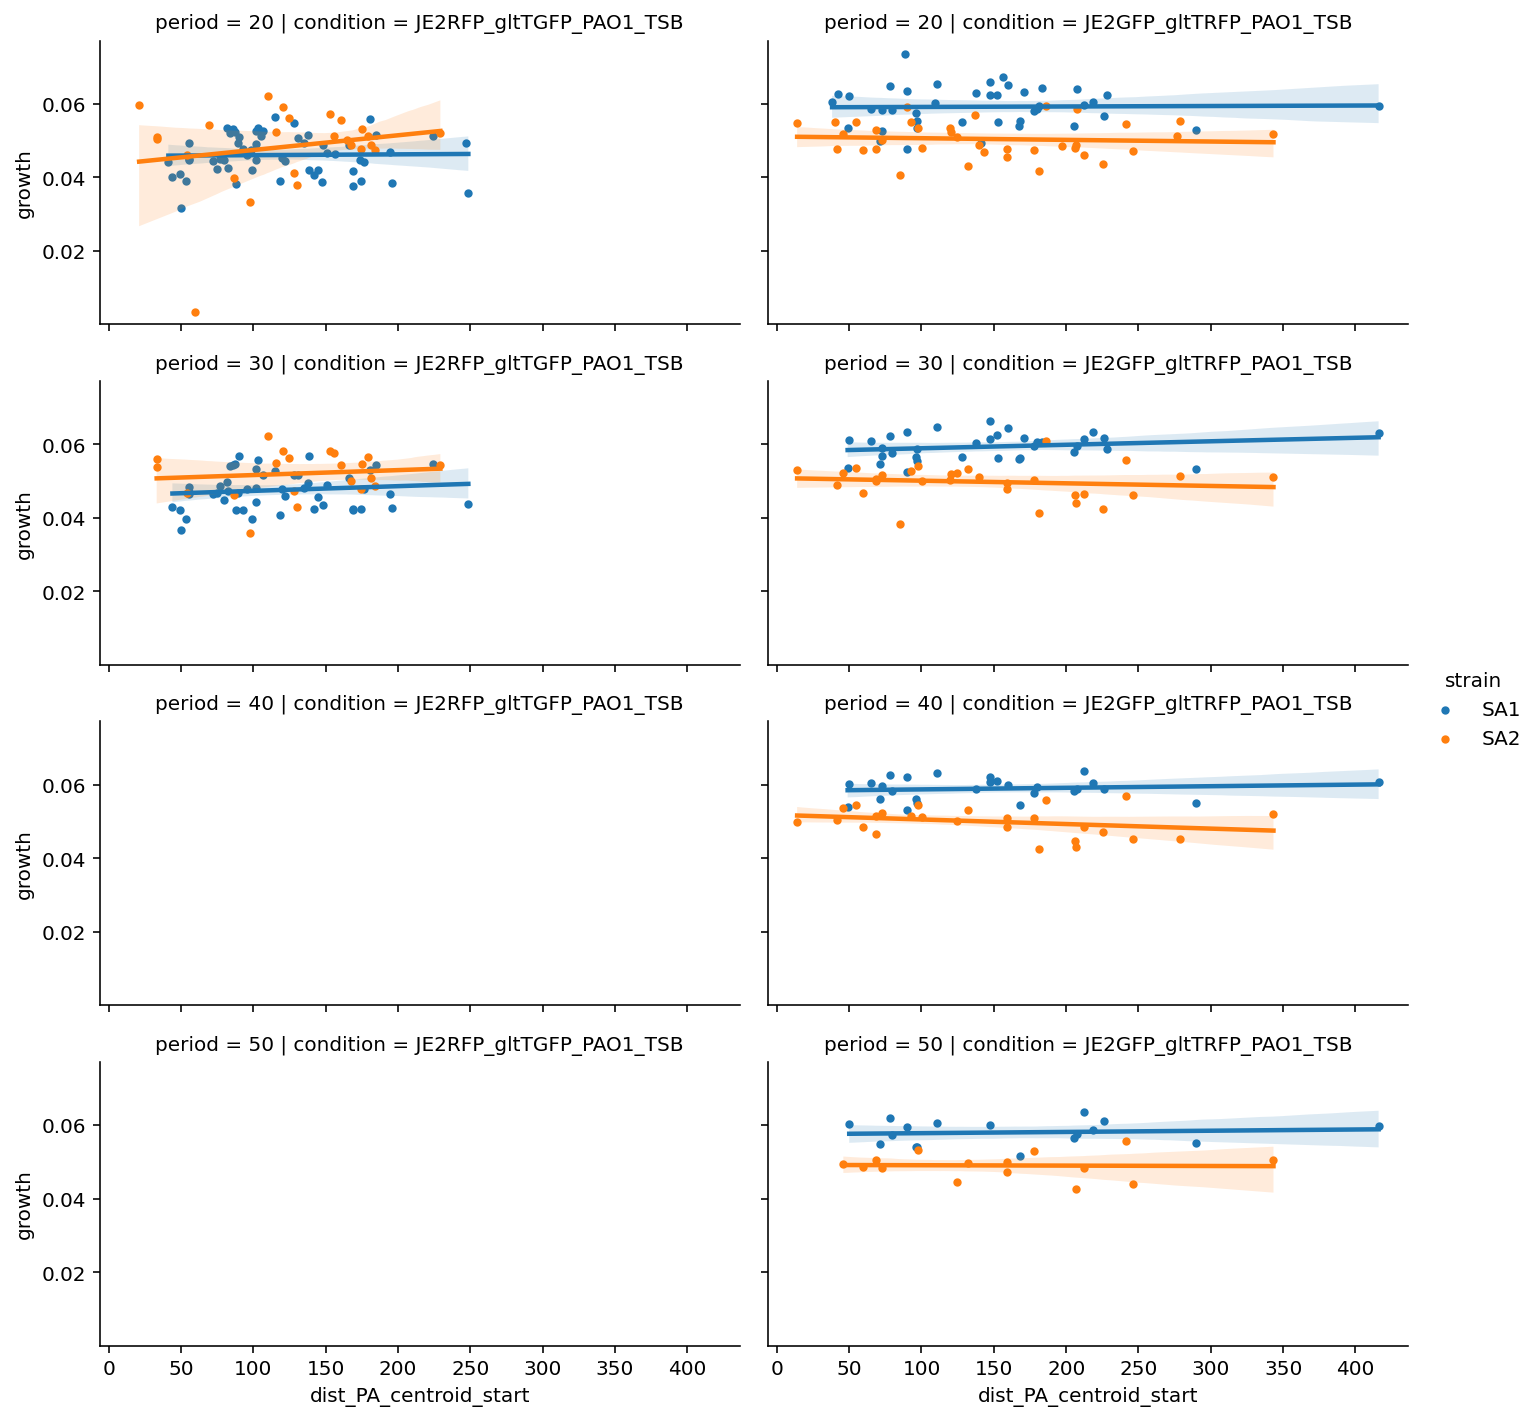

In [127]:
sns.lmplot(data=df_summary, x='dist_PA_centroid_min', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)

sns.lmplot(data=df_summary, x='dist_PA_centroid_av', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)

sns.lmplot(data=df_summary, x='dist_PA_centroid_start', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)